In [1]:
%cd "/home/ggarrett/lab/NB10422645 (Stage - Airbus)/"
from src.dataset import *
from src.dataset import DataSetFX
from src.surrogate.deeplearning.core import *
from sklearn import preprocessing
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import glob, os

datasets = []

transform = TransformDataFrame.from_ordered_dict(OrderedDict([
    ("tx1", (preprocessing.MinMaxScaler(feature_range=(-1, 1)), ["x1", "x2", "x3", "x4", "x5","x6","x7"])),
    ("fx1", (preprocessing.MinMaxScaler(feature_range=(0, 1)), ["f1", "f2", "f3", "f4"]))
]
))

transform_mod = TransformDataFrame.from_ordered_dict(OrderedDict([
    ("tx1", (preprocessing.MinMaxScaler(feature_range=(-1, 1)), ["x1", "x2", "x3", "x4", "x5","x6","x7"])),
    ("fx1", (preprocessing.MinMaxScaler(feature_range=(0, 1)), ["f1"]))
]
))

# count = 0
import os
for file in os.listdir("data/Kristen"):
    if "data" in file and "dataSetSplineYawVaryingSun" not in file and "mod" not in file:
        print(file)
        datasets.append(DataSetFX.from_mat(root_dir="data/Kristen/", file_name=file, transform=transform))


for file in os.listdir("data/Kristen"):
    if "data" in file and "mod" in file:
        print(file)
        datasets.append(DataSetFX.from_mat(root_dir="data/Kristen/", file_name=file, transform=transform_mod))




def save_transform_mat(dataset, name):
    

    input_transform = {
        "x_scale":dataset.transform.tx1.object.scale_,
        "x_min":dataset.transform.tx1.object.min_
    }

    output_transform = {
        "f_scale":dataset.transform.fx1.object.scale_,
        "f_min":dataset.transform.fx1.object.min_
    }

    from scipy import io

    io.savemat(f"{name}_input_transform.mat", input_transform)
    io.savemat(f"{name}_output_transform.mat", output_transform)


save_transform_mat(datasets[-1], "dataSet2SplineYawVaryingSun_mod")

# df_only_f3f4 = datasets[2].get_df()
# df_only_f3f4 = df_only_f3f4.drop(columns=["f1","f2", "f3"])

# ds_only_f3f4_fx = DataSetFX.df_to_fx(df_only_f3f4)

# ds_only_f3f4 = DataSetFX(input=ds_only_f3f4_fx["X"], output=ds_only_f3f4_fx["F"], file_name="test", root_dir="data/Kristen/")
# ds_only_f3f4.to_mat("testMod.mat")

/home/ggarrett/lab/NB10422645 (Stage - Airbus)
dataSet2SplineYawFixedSun.mat
dataSetSplineYawFixedSun.mat
dataSet2SplineYawVaryingSun.mat
dataSet2SplineYawFixedSun_mod2.mat
dataSet2SplineYawFixedSun_mod.mat


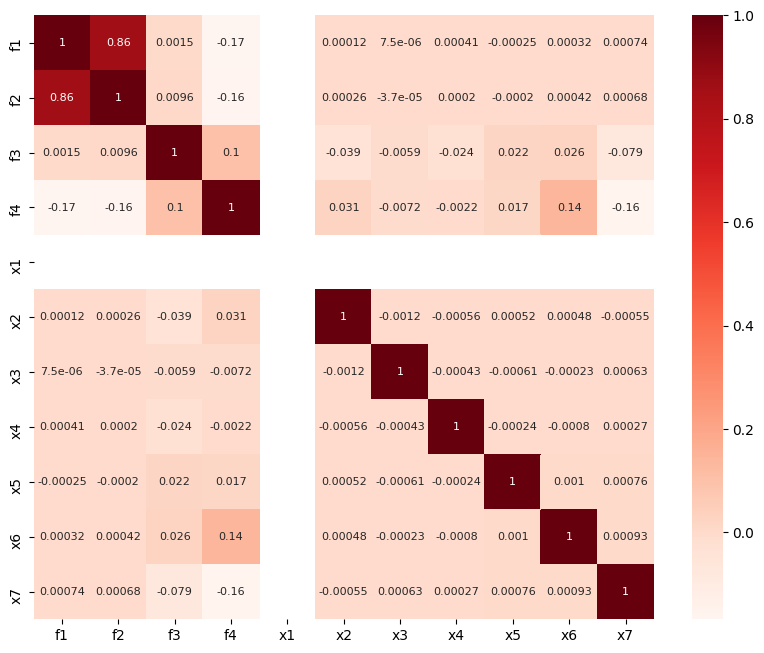

In [10]:
plt.figure(figsize=(10,8), dpi=100)
cor = datasets[0].get_df().corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, annot_kws={"size": 8})
plt.show()

/home/ggarrett/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ggarrett/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


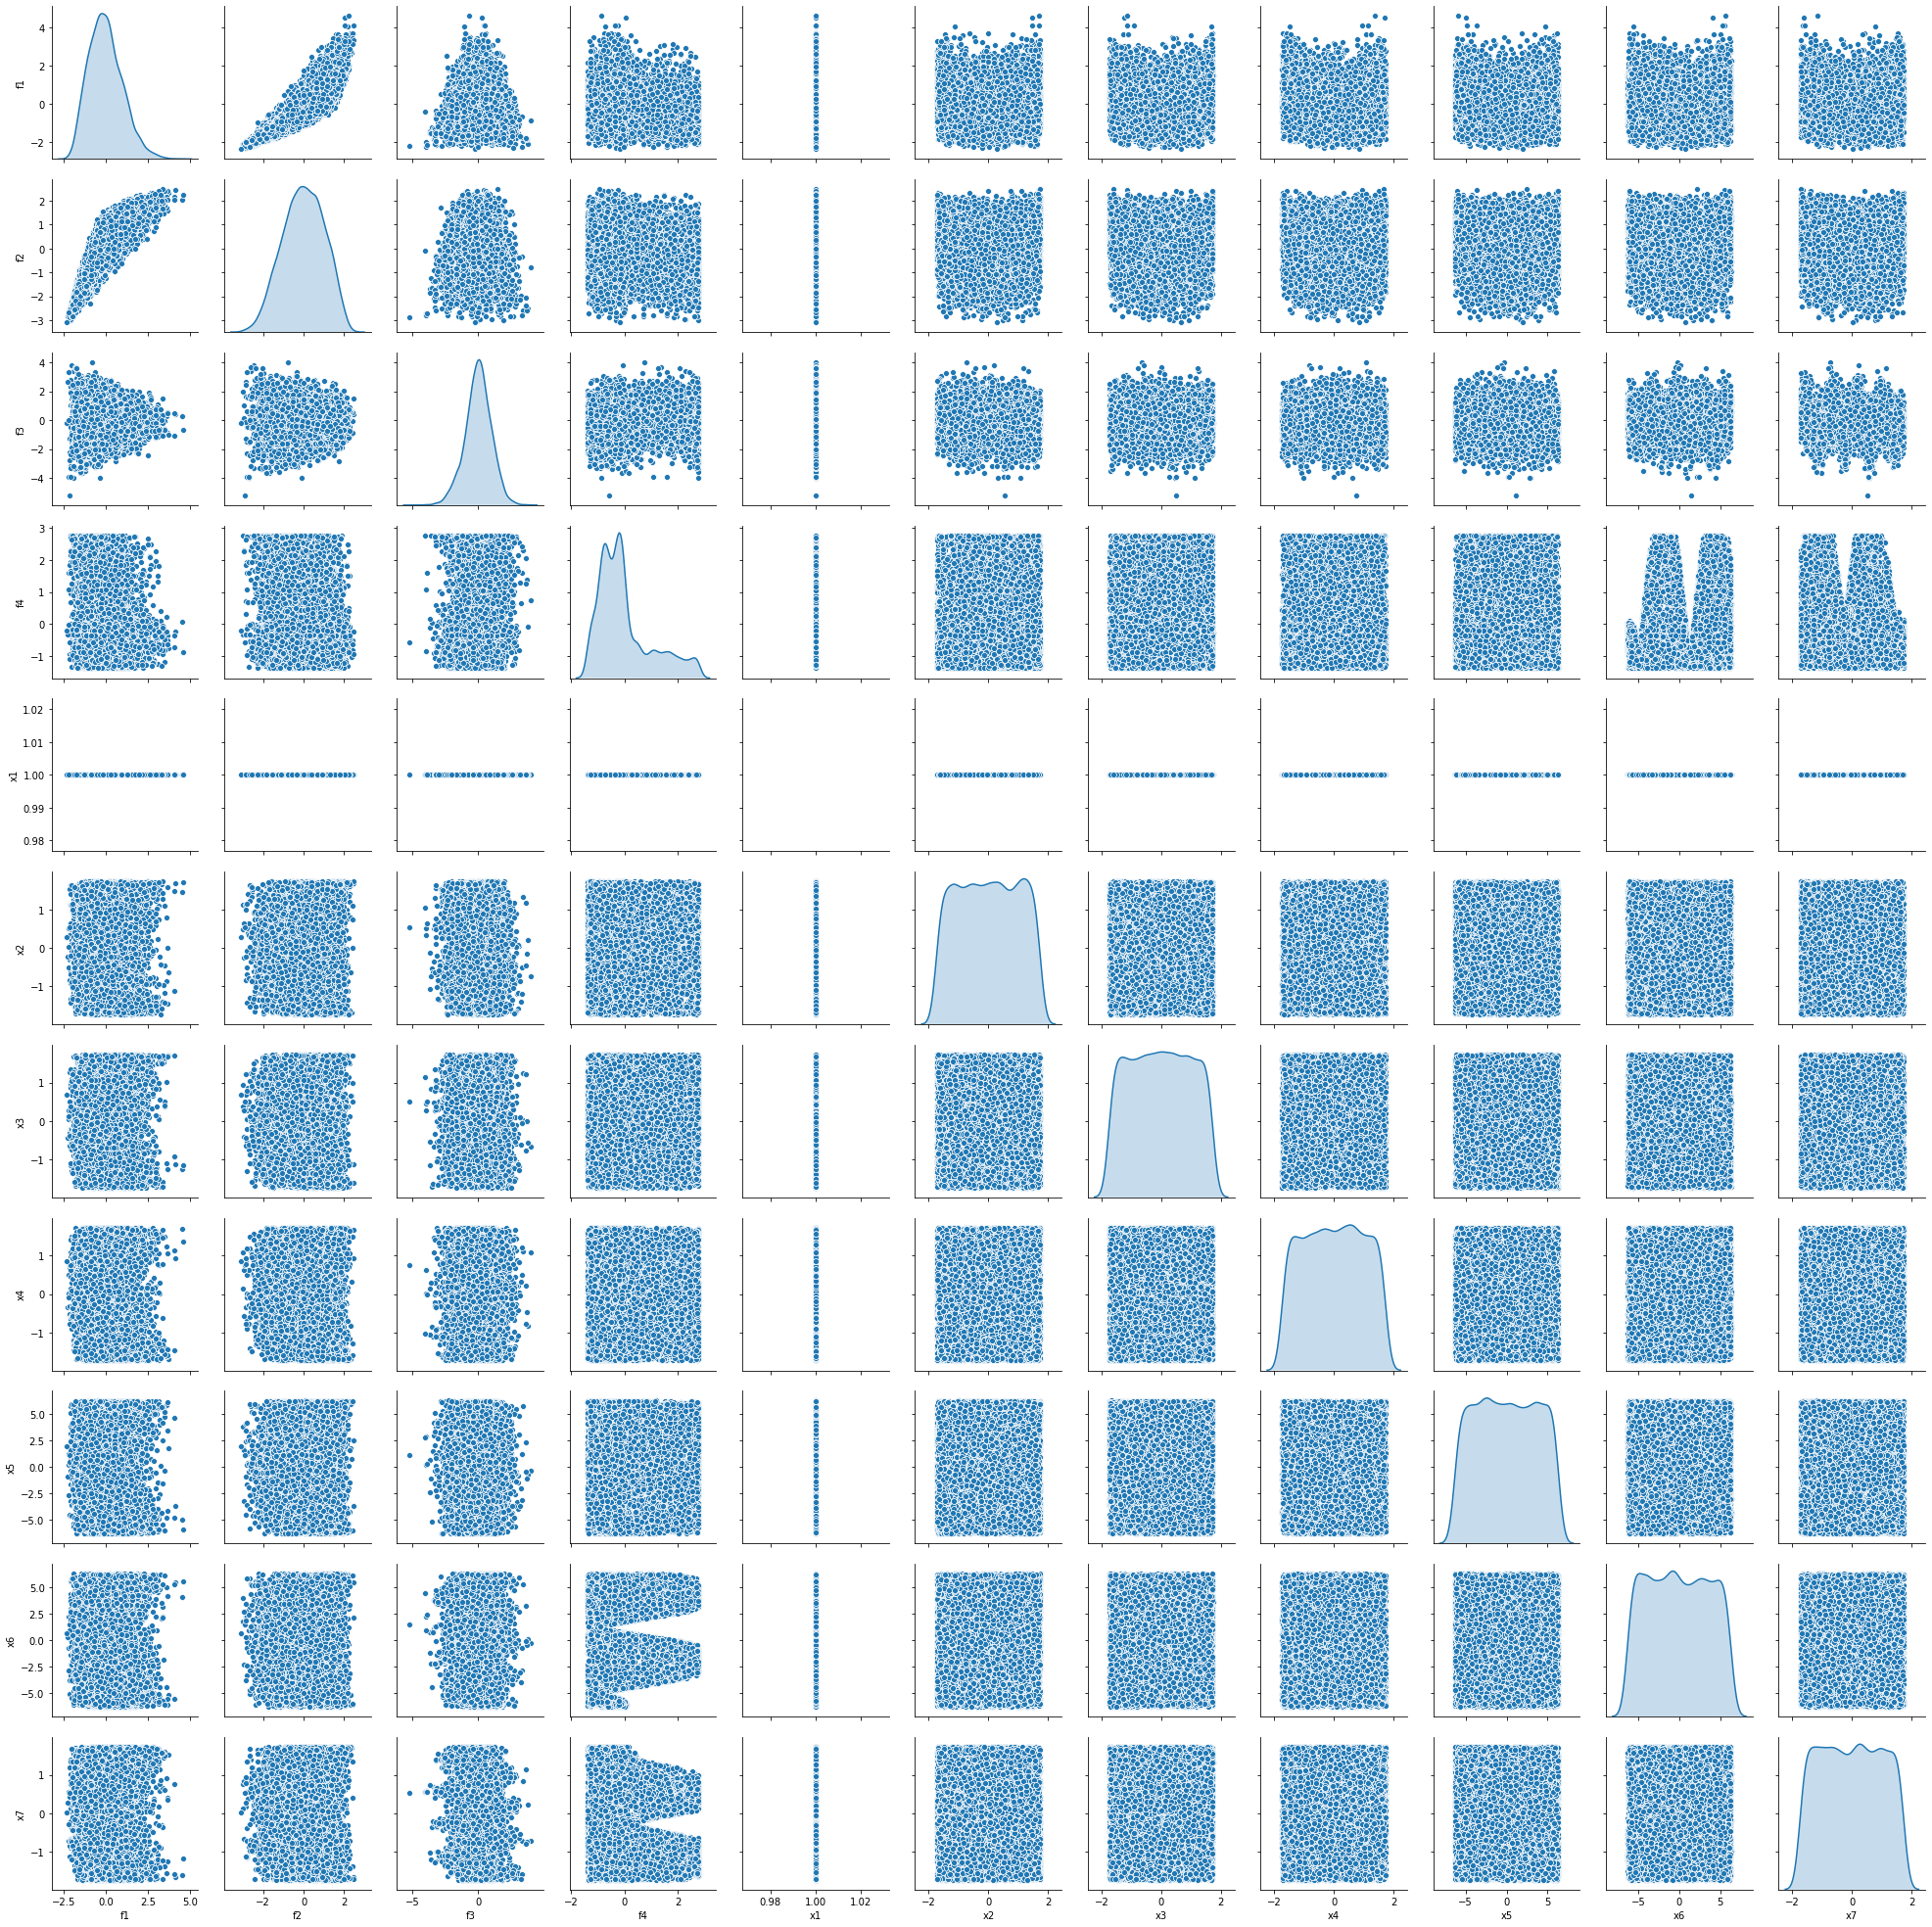

In [3]:
pp1 = sns.pairplot(datasets[0].get_df().sample(10000), diag_kind="kde")
plt.show()

In [2]:
%cd "~/lab/NB10422645 (Stage - Airbus)/"
from src.dataset import DataSetFX
from src.surrogate.deeplearning.core import *

# Deep learning imports.
import torch.nn as nn
import torch 
from collections import OrderedDict
from scipy import io
from src.surrogate.modules import ResidualBlock, BasicBlock, nn, RegressionOutput

# Visual.
import matplotlib
import matplotlib.pyplot as plt

/home/ggarrett/lab/NB10422645 (Stage - Airbus)


In [3]:
# Define training function.
def train_model(name, ds, model, model_folder, load=False):
    trainer = Trainer(model_folder, ds, model, torch.optim.Adam, torch.nn.L1Loss, num_epochs=50, batch_size=int(2e4), learning_rate=1e-3)
#     trainer.add_scheduler(torch.optim.lr_scheduler.MultiStepLR, milestones=[10], gamma=0.1)
    if load:
        trainer.load_checkpoint(model_folder)
    trainer.train()
    
# Define function to make tapered rest net.
def tapered_res_net(input_dim, h1_dim, num_h, hf_dim, output_dim, activation="sigmoid"):
    _list = []
    _list.append(BasicBlock(input_dim, h1_dim,  activation=activation))
    _dhn = (h1_dim - hf_dim) / num_h
    for h_f in range(num_h):
        _list.append(BasicBlock(int(h1_dim - h_f * _dhn), int(h1_dim - (h_f + 1) * _dhn),  activation=activation))
        _list.append(ResidualBlock(int(h1_dim - (h_f + 1) * _dhn), activation=activation))
    _list.append(RegressionOutput(int(hf_dim), output_dim))
    return nn.Sequential(*_list)

# Define function to make tapered net.
def tapered_net(input_dim, h1_dim, num_h, hf_dim, output_dim, activation="sigmoid"):
    _list = []
    _list.append(BasicBlock(input_dim, h1_dim,  activation=activation))
    _dhn = (h1_dim - hf_dim) / num_h
    for h_f in range(num_h):
        _list.append(BasicBlock(int(h1_dim - h_f * _dhn), int(h1_dim - (h_f + 1) * _dhn),  activation=activation))
    _list.append(RegressionOutput(int(hf_dim), output_dim))
    return nn.Sequential(*_list)

In [10]:
# Experiment 1: Tapered res net - dataSet2SplineYawFixedSun.mat
name = "experiment1_dataSet2SplineYawFixedSun"
folder = f"models/save3/{name}"

ds = datasets[0]

model = tapered_res_net(
    input_dim = ds.input_size,
    output_dim = ds.output_size,
    h1_dim = 128,
    num_h = 1,
    hf_dim = 64)

train_model(name, ds, model, folder, False)

Epoch [  1  / 21  ]  |  Train Loss:  0.594780  |  Test Loss:  0.369732  |  lr:  0.01000
Epoch [  2  / 21  ]  |  Train Loss:  0.264863  |  Test Loss:  0.186203  |  lr:  0.01000
Epoch [  3  / 21  ]  |  Train Loss:  0.149991  |  Test Loss:  0.118557  |  lr:  0.01000
Epoch [  4  / 21  ]  |  Train Loss:  0.093714  |  Test Loss:  0.075793  |  lr:  0.01000
Epoch [  5  / 21  ]  |  Train Loss:  0.069816  |  Test Loss:  0.064473  |  lr:  0.01000
Epoch [  6  / 21  ]  |  Train Loss:  0.063982  |  Test Loss:  0.060610  |  lr:  0.01000
Epoch [  7  / 21  ]  |  Train Loss:  0.059076  |  Test Loss:  0.057401  |  lr:  0.01000
Epoch [  8  / 21  ]  |  Train Loss:  0.055308  |  Test Loss:  0.052430  |  lr:  0.01000
Epoch [  9  / 21  ]  |  Train Loss:  0.051513  |  Test Loss:  0.048888  |  lr:  0.01000
Epoch [ 10  / 21  ]  |  Train Loss:  0.049121  |  Test Loss:  0.047843  |  lr:  0.01000
Epoch [ 11  / 21  ]  |  Train Loss:  0.048576  |  Test Loss:  0.047683  |  lr:  0.01000
Epoch [ 12  / 21  ]  |  Train Lo

In [11]:
# Experiment 2: Tapered res net - dataSet2SplineYawFixedSun.mat
name = "experiment2_dataSet2SplineYawFixedSun"
folder = f"models/save3/{name}"

ds = datasets[0]

model = tapered_res_net(
    input_dim = ds.input_size,
    output_dim = ds.output_size,
    h1_dim = 128,
    num_h = 4,
    hf_dim = 64)

train_model(name, ds, model, folder, False)

Epoch [  1  / 21  ]  |  Train Loss:  0.403299  |  Test Loss:  0.228940  |  lr:  0.01000
Epoch [  2  / 21  ]  |  Train Loss:  0.174760  |  Test Loss:  0.137548  |  lr:  0.01000
Epoch [  3  / 21  ]  |  Train Loss:  0.127644  |  Test Loss:  0.120926  |  lr:  0.01000
Epoch [  4  / 21  ]  |  Train Loss:  0.104275  |  Test Loss:  0.094829  |  lr:  0.01000
Epoch [  5  / 21  ]  |  Train Loss:  0.089026  |  Test Loss:  0.081584  |  lr:  0.01000
Epoch [  6  / 21  ]  |  Train Loss:  0.083698  |  Test Loss:  0.079183  |  lr:  0.01000
Epoch [  7  / 21  ]  |  Train Loss:  0.077305  |  Test Loss:  0.070180  |  lr:  0.01000
Epoch [  8  / 21  ]  |  Train Loss:  0.064688  |  Test Loss:  0.061987  |  lr:  0.01000
Epoch [  9  / 21  ]  |  Train Loss:  0.058504  |  Test Loss:  0.055334  |  lr:  0.01000
Epoch [ 10  / 21  ]  |  Train Loss:  0.055868  |  Test Loss:  0.052724  |  lr:  0.01000
Epoch [ 11  / 21  ]  |  Train Loss:  0.053499  |  Test Loss:  0.049322  |  lr:  0.01000
Epoch [ 12  / 21  ]  |  Train Lo

In [12]:
# Experiment 3: Tapered res net - dataSet2SplineYawFixedSun.mat
name = "experiment3_dataSet2SplineYawFixedSun"
folder = f"models/save3/{name}"

ds = datasets[0]

model = tapered_res_net(
    input_dim = ds.input_size,
    output_dim = ds.output_size,
    h1_dim = 128*2,
    num_h = 4,
    hf_dim = 64*2)

train_model(name, ds, model, folder, False)

Epoch [  1  / 21  ]  |  Train Loss:  0.393559  |  Test Loss:  0.201635  |  lr:  0.01000
Epoch [  2  / 21  ]  |  Train Loss:  0.149291  |  Test Loss:  0.116653  |  lr:  0.01000
Epoch [  3  / 21  ]  |  Train Loss:  0.109791  |  Test Loss:  0.102304  |  lr:  0.01000
Epoch [  4  / 21  ]  |  Train Loss:  0.100078  |  Test Loss:  0.090598  |  lr:  0.01000
Epoch [  5  / 21  ]  |  Train Loss:  0.082606  |  Test Loss:  0.069919  |  lr:  0.01000
Epoch [  6  / 21  ]  |  Train Loss:  0.065924  |  Test Loss:  0.061023  |  lr:  0.01000
Epoch [  7  / 21  ]  |  Train Loss:  0.056001  |  Test Loss:  0.049902  |  lr:  0.01000
Epoch [  8  / 21  ]  |  Train Loss:  0.049739  |  Test Loss:  0.048173  |  lr:  0.01000
Epoch [  9  / 21  ]  |  Train Loss:  0.045646  |  Test Loss:  0.050902  |  lr:  0.01000
Epoch [ 10  / 21  ]  |  Train Loss:  0.044274  |  Test Loss:  0.043926  |  lr:  0.01000
Epoch [ 11  / 21  ]  |  Train Loss:  0.041550  |  Test Loss:  0.038511  |  lr:  0.01000
Epoch [ 12  / 21  ]  |  Train Lo

In [13]:
# Experiment 4: Tapered res net - dataSet2SplineYawFixedSun.mat
name = "experiment4_dataSet2SplineYawFixedSun"
folder = f"models/save3/{name}"

ds = datasets[0]

model = tapered_res_net(
    input_dim = ds.input_size,
    output_dim = ds.output_size,
    h1_dim = 128*2,
    num_h = 1,
    hf_dim = 64*2)

train_model(name, ds, model, folder, False)

Epoch [  1  / 21  ]  |  Train Loss:  0.580528  |  Test Loss:  0.347536  |  lr:  0.01000
Epoch [  2  / 21  ]  |  Train Loss:  0.243901  |  Test Loss:  0.169290  |  lr:  0.01000
Epoch [  3  / 21  ]  |  Train Loss:  0.137088  |  Test Loss:  0.097005  |  lr:  0.01000
Epoch [  4  / 21  ]  |  Train Loss:  0.077370  |  Test Loss:  0.063039  |  lr:  0.01000
Epoch [  5  / 21  ]  |  Train Loss:  0.059499  |  Test Loss:  0.055597  |  lr:  0.01000
Epoch [  6  / 21  ]  |  Train Loss:  0.053249  |  Test Loss:  0.053464  |  lr:  0.01000
Epoch [  7  / 21  ]  |  Train Loss:  0.049427  |  Test Loss:  0.046230  |  lr:  0.01000
Epoch [  8  / 21  ]  |  Train Loss:  0.046507  |  Test Loss:  0.045578  |  lr:  0.01000
Epoch [  9  / 21  ]  |  Train Loss:  0.045072  |  Test Loss:  0.043368  |  lr:  0.01000
Epoch [ 10  / 21  ]  |  Train Loss:  0.042565  |  Test Loss:  0.041263  |  lr:  0.01000
Epoch [ 11  / 21  ]  |  Train Loss:  0.041125  |  Test Loss:  0.040559  |  lr:  0.01000
Epoch [ 12  / 21  ]  |  Train Lo

In [ ]:
# Experiemnt 7 dataSet2SplineYawVaryingSun
name = "experiment7_dataSet2SplineYawVaryingSun"
folder = f"models/save3/{name}"

ds = datasets[2]

model = tapered_res_net(
    input_dim = ds.input_size,
    output_dim = ds.output_size,
    h1_dim = 128*2,
    num_h = 4,
    hf_dim = 64*2)

train_model(name, ds, model, folder, True)

In [4]:
# Experiemnt 8 dataSet2SplineYawVaryingSun
name = "experiment8_dataSet2SplineYawVaryingSun"
folder = f"models/save3/{name}"

ds = datasets[2]

model = tapered_res_net(
    input_dim = ds.input_size,
    output_dim = ds.output_size,
    h1_dim = 128*2,
    num_h = 4,
    hf_dim = 64*2)

train_model(name, ds, model, folder, True)

Epoch [  7  / 21  ]  |  Train Loss:  0.018038  |  Test Loss:  0.015793  |  lr:  0.10000
Epoch [  8  / 21  ]  |  Train Loss:  0.013333  |  Test Loss:  0.012169  |  lr:  0.10000
Epoch [  9  / 21  ]  |  Train Loss:  0.011598  |  Test Loss:  0.011302  |  lr:  0.10000
Epoch [ 10  / 21  ]  |  Train Loss:  0.010849  |  Test Loss:  0.010582  |  lr:  0.10000
Epoch [ 11  / 21  ]  |  Train Loss:  0.009974  |  Test Loss:  0.009405  |  lr:  0.10000
Epoch [ 12  / 21  ]  |  Train Loss:  0.008317  |  Test Loss:  0.007632  |  lr:  0.10000
Epoch [ 13  / 21  ]  |  Train Loss:  0.006858  |  Test Loss:  0.006596  |  lr:  0.10000
Epoch [ 14  / 21  ]  |  Train Loss:  0.006174  |  Test Loss:  0.006045  |  lr:  0.10000
Epoch [ 15  / 21  ]  |  Train Loss:  0.005655  |  Test Loss:  0.005653  |  lr:  0.10000
Epoch [ 16  / 21  ]  |  Train Loss:  0.005354  |  Test Loss:  0.005397  |  lr:  0.10000
Epoch [ 17  / 21  ]  |  Train Loss:  0.005059  |  Test Loss:  0.005115  |  lr:  0.01000
Epoch [ 18  / 21  ]  |  Train Lo

In [4]:
# Experiemnt 9 dataSet2SplineYawVaryingSun
name = "experiment9_dataSet2SplineYawVaryingSun"
folder = f"models/save3/{name}"

ds = datasets[2]

model = tapered_net(
    activation="leaky_relu",
    input_dim = ds.input_size,
    output_dim = ds.output_size,
    h1_dim = 128*2,
    num_h = 4,
    hf_dim = 64*2)

train_model(name, ds, model, folder, False)

Epoch [  1  / 21  ]  |  Train Loss:  0.175559  |  Test Loss:  0.024178  |  lr:  0.10000
Epoch [  2  / 21  ]  |  Train Loss:  0.019086  |  Test Loss:  0.011811  |  lr:  0.10000
Epoch [  3  / 21  ]  |  Train Loss:  0.011251  |  Test Loss:  0.010743  |  lr:  0.10000
Epoch [  4  / 21  ]  |  Train Loss:  0.010395  |  Test Loss:  0.010216  |  lr:  0.10000
Epoch [  5  / 21  ]  |  Train Loss:  0.010001  |  Test Loss:  0.009957  |  lr:  0.10000
Epoch [  6  / 21  ]  |  Train Loss:  0.009765  |  Test Loss:  0.009736  |  lr:  0.10000
Epoch [  7  / 21  ]  |  Train Loss:  0.009436  |  Test Loss:  0.009242  |  lr:  0.10000
Epoch [  8  / 21  ]  |  Train Loss:  0.008556  |  Test Loss:  0.007399  |  lr:  0.10000
Epoch [  9  / 21  ]  |  Train Loss:  0.005813  |  Test Loss:  0.005026  |  lr:  0.10000
Epoch [ 10  / 21  ]  |  Train Loss:  0.004566  |  Test Loss:  0.004504  |  lr:  0.10000
Epoch [ 11  / 21  ]  |  Train Loss:  0.004323  |  Test Loss:  0.004459  |  lr:  0.01000
Interrupted


SystemExit: 0

/home/ggarrett/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
# Experiemnt 10 dataSet2SplineYawVaryingSun
name = "experiment10_dataSet2SplineYawVaryingSun"
folder = f"models/save3/{name}"

ds = datasets[-2]

# print(ds.get_df())

print(ds.input_size)
print(ds.output_size)


model = tapered_net(
    activation="sigmoid",
    input_dim = ds.input_size,
    output_dim = ds.output_size,
    h1_dim = 128*2,
    num_h = 4,
    hf_dim = 64*2)

train_model(name, ds, model, folder, False)

7
1
Epoch [  1  / 21  ]  |  Train Loss:  2.111875  |  Test Loss:  0.037969  |  lr:  0.10000
Epoch [  2  / 21  ]  |  Train Loss:  0.025539  |  Test Loss:  0.013430  |  lr:  0.10000
Epoch [  3  / 21  ]  |  Train Loss:  0.011640  |  Test Loss:  0.010275  |  lr:  0.10000
Epoch [  4  / 21  ]  |  Train Loss:  0.010391  |  Test Loss:  0.009651  |  lr:  0.10000
Epoch [  5  / 21  ]  |  Train Loss:  0.010026  |  Test Loss:  0.009417  |  lr:  0.10000
Epoch [  6  / 21  ]  |  Train Loss:  0.009839  |  Test Loss:  0.009649  |  lr:  0.10000
Epoch [  7  / 21  ]  |  Train Loss:  0.009837  |  Test Loss:  0.009323  |  lr:  0.10000
Epoch [  8  / 21  ]  |  Train Loss:  0.009840  |  Test Loss:  0.009550  |  lr:  0.10000
Epoch [  9  / 21  ]  |  Train Loss:  0.009889  |  Test Loss:  0.009257  |  lr:  0.10000
Epoch [ 10  / 21  ]  |  Train Loss:  0.009702  |  Test Loss:  0.009224  |  lr:  0.10000
Epoch [ 11  / 21  ]  |  Train Loss:  0.009607  |  Test Loss:  0.009100  |  lr:  0.01000
Epoch [ 12  / 21  ]  |  Trai

In [8]:
# Experiemnt 11 dataSet2SplineYawVaryingSun
name = "experiment11_dataSet2SplineYawVaryingSun"
folder = f"models/save3/{name}"

ds = datasets[-1]

# print(ds.get_df())

print(ds.input_size)
print(ds.output_size)


model = tapered_res_net(
    activation="sigmoid",
    input_dim = ds.input_size,
    output_dim = ds.output_size,
    h1_dim = 50,
    num_h = 5,
    hf_dim = 20)

train_model(name, ds, model, folder, False)

7
2
Epoch [  1  / 50  ]  |  Train Loss:  0.501835  |  Test Loss:  0.395294  |  lr:  0.00100
Epoch [  2  / 50  ]  |  Train Loss:  0.285293  |  Test Loss:  0.168589  |  lr:  0.00100
Epoch [  3  / 50  ]  |  Train Loss:  0.114673  |  Test Loss:  0.092552  |  lr:  0.00100
Epoch [  4  / 50  ]  |  Train Loss:  0.087078  |  Test Loss:  0.081794  |  lr:  0.00100
Epoch [  5  / 50  ]  |  Train Loss:  0.079940  |  Test Loss:  0.075847  |  lr:  0.00100
Epoch [  6  / 50  ]  |  Train Loss:  0.075579  |  Test Loss:  0.073259  |  lr:  0.00100
Epoch [  7  / 50  ]  |  Train Loss:  0.072745  |  Test Loss:  0.069107  |  lr:  0.00100
Epoch [  8  / 50  ]  |  Train Loss:  0.070155  |  Test Loss:  0.068070  |  lr:  0.00100
Epoch [  9  / 50  ]  |  Train Loss:  0.067911  |  Test Loss:  0.065255  |  lr:  0.00100
Epoch [ 10  / 50  ]  |  Train Loss:  0.066387  |  Test Loss:  0.065596  |  lr:  0.00100
Interrupted


SystemExit: 0

/home/ggarrett/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
dummy_input = torch.randn(1, 7, 1, 1, device='cuda')

input_names = ["x"]
output_names = ["f"]

model.eval()
torch.onnx.export(model, dummy_input, f"{name}.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%x : Float(1, 7, 1, 1),
      %0.block.0.weight : Float(50, 7, 1, 1),
      %0.block.0.bias : Float(50),
      %0.block.2.weight : Float(50),
      %0.block.2.bias : Float(50),
      %0.block.2.running_mean : Float(50),
      %0.block.2.running_var : Float(50),
      %0.block.2.num_batches_tracked : Long(),
      %1.block.0.weight : Float(44, 50, 1, 1),
      %1.block.0.bias : Float(44),
      %1.block.2.weight : Float(44),
      %1.block.2.bias : Float(44),
      %1.block.2.running_mean : Float(44),
      %1.block.2.running_var : Float(44),
      %1.block.2.num_batches_tracked : Long(),
      %2.blocks.0.weight : Float(44, 44, 1, 1),
      %2.blocks.0.bias : Float(44),
      %2.blocks.2.weight : Float(44, 44, 1, 1),
      %2.blocks.2.bias : Float(44),
      %2.blocks.3.weight : Float(44),
      %2.blocks.3.bias : Float(44),
      %2.blocks.3.running_mean : Float(44),
      %2.blocks.3.running_var : Float(44),
      %2.blocks.3.num_batches_tracked : Long(),
      %2.shortcut.weig